# User representation
 - As was already mentioned earlier it is impossible to supply every recommender system with all raw data comming from other systems due to computational limitations and certain amount of compression is therefore required
 - Also supplying recommender system with additional data will allow us to personalize model and help us deal with user [cold-start problem](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems))
 - We will try to create user representation and generally describe methods for obtaining user dense representation also known as embedding from user page visits
 - Supervised aproach:
   - Assume that you own large portfolio of various websites and you could categorize websites into the following categories: sport, news and tabloid 
   - Assume user $U$ visited following webpages [PV1](https://www.sport.cz/clanek/fotbal-ceska-1-liga-fotbal-online-provod-tahne-slavii-na-prvni-misto-banik-doma-zklamal-jablonec-na-snehu-vyrovnal-3273466), [PV2](https://www.sport.cz/clanek/hokej-jagr-mladez-na-kladne-je-i-ma-ostuda-se-vzkrisenim-slavne-znacky-mu-pomuze-plekanec-coby-sef-3274015), [PV3](https://www.super.cz/862981-obrazem-21-modelu-z-ceskeho-plesu-z-obrich-dekoltu-a-rozparku-se-vam-zatoci-hlava.html)
   - Then one could represent $U$ as sequence of the following categories: sport, sport, tabloid
   - This sequence can be further preprocessed into histogram or viewed as text document and be processed by some NLP technique such as [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)
   - Having such information associated with user or a page will be important for user and item cold-start mitigation
   - The main question is how can one receive such classification? One needs to build online classification service that will detect newly created web pages and classify them appropriately
 - Unsupervised aproach:
    - In an unsupervised aproach one does not need any additional information regarding user content labels - only sequence of visited webpage views for every user
    - Assume that user $U$ has visided pages PV1, PV2, PV3 then we can treat user as a document and visited web pages as words and create word embeddings by using NLP techniques
    - One can then represent $U$ as a sequence of vectors which can be further aggregated into single vector
    - There are many NLP libraries available:
      - [fasttext](https://fasttext.cc/)
      - [starspace](https://github.com/facebookresearch/StarSpace)
      - [doc2vec](https://radimrehurek.com/gensim/models/doc2vec.html)
      - [word2vec](https://radimrehurek.com/gensim/models/word2vec.html)
      - Also one can choose to use more complex methods such as [bert](https://github.com/google-research/electra)
      
      
  - Article's categories and subcategories are already available in MIND dataset therefore we will focus on creating unsupervised user representation using `fasttext` and visualizing it via [umap](https://umap-learn.readthedocs.io/en/latest/parameters.html) dimensionality reduction algorithm


In [2]:
!pip install git+https://github.com/seznam/MLPrague-2022.git umap-learn==0.5.2 fasttext==0.9.2

  Cloning https://github.com/seznam/MLPrague-2022.git to /tmp/pip-req-build-1xp6q7dk
  Running command git clone -q https://github.com/seznam/MLPrague-2022.git /tmp/pip-req-build-1xp6q7dk
     |████████████████████████████████| 86 kB 4.0 MB/s 
     |████████████████████████████████| 68 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 27.9 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for mlprague22: filename=mlprague22-0.0.0-py3-none-any.whl size=4390 sha256=5783bc99eb44067ec45d64ceec3d912a346cc5544564210c1862316727cdf503
  Stored in directory: /tmp/pip-ephem-wheel-cache-yua617f9/wheels/8e/30/46/f600aaa9e010eb66abaae33828e5ee3596fcdccb523d593440
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=75b356c35c9bf733e7ce59b176c7d8c5c55eb4a32ed8184d68f5ee9a4079f123
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for fasttext: file

In [3]:
import os

try:
    from google.colab import drive

    drive.mount('/content/gdrive', force_remount=True)
    BASE_DIR = "/content/gdrive/MyDrive/mlprague2022"
    IN_COLAB = True
except:
    BASE_DIR = ".."
    IN_COLAB = False

from tqdm.auto import tqdm
import fasttext
import numpy as np
import pandas as pd
import umap
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/gdrive


In [4]:
OUTPUT_DIR = os.path.join(BASE_DIR, "data/mind_cold_start_datasets_basic/")

COLD_START_BEHAVIORS_TRAIN = os.path.join(OUTPUT_DIR, "behaviors_train.tsv")
COLD_START_BEHAVIORS_TEST = os.path.join(OUTPUT_DIR, "behaviors_test.tsv")
NEWS_CATALOGUE_TRAIN = os.path.join(OUTPUT_DIR, "news_catalogue_train.tsv")
NEWS_CATALOGUE_TEST = os.path.join(OUTPUT_DIR, "news_catalogue_test.tsv")
AUXILIARY_DATA_CATALOGUE_TRAIN = os.path.join(OUTPUT_DIR, "auxiliary_data_catalogue_train.tsv")

EMBEDDINGS_OUTPUT_DIR = os.path.join(OUTPUT_DIR, "embeddings")
FT_HISTORY_EMBEDDINGS_TRAIN = "ft_histories_train.vec"
FT_HISTORY_EMBEDDINGS_TEST = "ft_histories_test.vec"
EMBEDDINGS_OUTPUT_TRAIN = os.path.join(EMBEDDINGS_OUTPUT_DIR, FT_HISTORY_EMBEDDINGS_TRAIN)
EMBEDDINGS_OUTPUT_TEST = os.path.join(EMBEDDINGS_OUTPUT_DIR, FT_HISTORY_EMBEDDINGS_TEST)

In [6]:
def visualize_embeddings_umap(embeddings_train, embeddings_test, labels_train, labels_test, info, ignore_labels):
  """Functionality for embedding visualization."""
  label2id = {l: i for i, l in enumerate(sorted(set([_l for _l in labels_train if str(_l) != 'nan'])))}
  pal = sns.color_palette(n_colors=len(label2id))

  reducer = umap.UMAP(metric="cosine", )
  umap_embeddings_train = reducer.fit_transform(embeddings_train)
  umap_embeddings_test = reducer.transform(embeddings_test)

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))
  fig.suptitle(f"UMAP projection of embeddings - {info}", fontsize=20)

  def _plot(ax, umap_embeddings, labels):
      for label in list(label2id.keys()):
          if label in ignore_labels:
              continue
          mask = labels == label
          ax.scatter(
              umap_embeddings[mask, 0],
              umap_embeddings[mask, 1],
              color=pal[label2id[label]],
              label=label
          )
      ax.legend()
      ax.set_aspect('equal', 'datalim')

  _plot(ax1, umap_embeddings_train, labels_train)
  _plot(ax2, umap_embeddings_test, labels_test)

In [7]:
behaviors_train = pd.read_csv(COLD_START_BEHAVIORS_TRAIN, sep="\t")
behaviors_test = pd.read_csv(COLD_START_BEHAVIORS_TEST, sep="\t")
news_train = pd.read_csv(NEWS_CATALOGUE_TRAIN, sep="\t")

# use only unique users for training
dataset_train_unique_users = (
    behaviors_train.sort_values("time")
    .drop_duplicates("userid", keep="first")
    .reset_index()
)
dataset_test_unique_users = (
    behaviors_test.sort_values("time")
    .drop_duplicates("userid", keep="first")
    .reset_index()
)

In [8]:
# fasttext requires training data to be in a specific format
# every line will contain user page views delimited by space
with open('/tmp/ft_histories_train.txt', 'w') as f:
    for h in dataset_train_unique_users["history_all"]:
        f.write(f"{h}\n")

In [9]:
# training of fasttext model
# fasttext would normaly try to derive sub-word embeddings which might make sense for text documents but it is useless for webpages => maxn=0
ft_model_histories = fasttext.train_unsupervised("/tmp/ft_histories_train.txt", maxn=0, dim=100, epoch=10)

In [10]:
# certain articles occure very little - it does make sense to visualize them as they would harm our visualization => filter them out
aux_catalogue_train = pd.read_csv(AUXILIARY_DATA_CATALOGUE_TRAIN, sep="\t")

histories_popularity_train = (
    dataset_train_unique_users.assign(
        history_all_arr=lambda x: [r.split() for r in x["history_all"]]
    )[["history_all_arr"]]
    .explode("history_all_arr")
    .value_counts()
    .reset_index()
)

histories_popularity_test = (
    dataset_test_unique_users.assign(
        history_all_arr=lambda x: [r.split() for r in x["history_all"]]
    )[["history_all_arr"]]
    .explode("history_all_arr")
    .value_counts()
    .reset_index()
)

histories_popularity_train.columns = ["newsid", "user_history_occurences"]
histories_popularity_test.columns = ["newsid", "user_history_occurences"]

aux_catalogue_train_no_longtail = aux_catalogue_train.merge(histories_popularity_train, on="newsid").query("user_history_occurences >= 5")
aux_catalogue_test_no_longtail =  aux_catalogue_train.merge(histories_popularity_test, on="newsid").query("user_history_occurences >= 5")

In [11]:
# gather embeddings for arcticles 
ft_histories_item_vectors_train_viz = np.array(
    [
        np.array(ft_model_histories.get_word_vector(x))
        for x in tqdm(aux_catalogue_train_no_longtail["newsid"])
    ]
)

ft_histories_item_vectors_test_viz = np.array(
    [
        np.array(ft_model_histories.get_word_vector(x))
        for x in tqdm(aux_catalogue_test_no_longtail["newsid"])
    ]
)



  0%|          | 0/12937 [00:00<?, ?it/s]

  0%|          | 0/13897 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


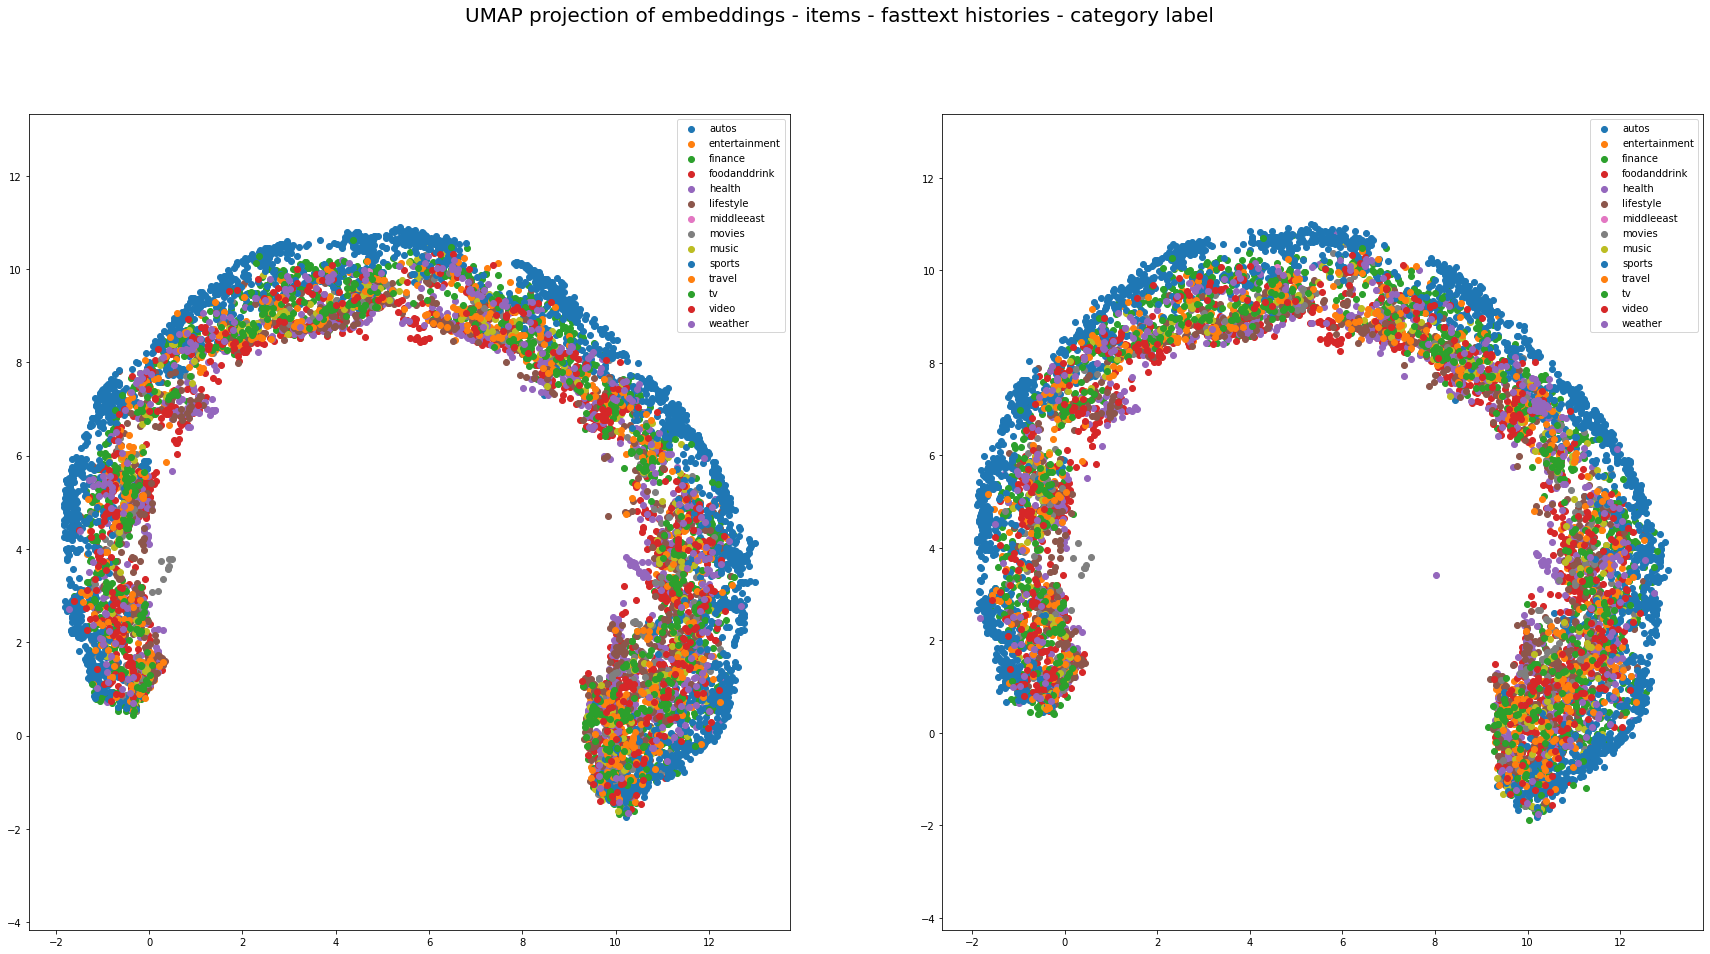

In [12]:
# visualize items in train/test dataset
# label articles in the vector space by their category 
visualize_embeddings_umap(
    ft_histories_item_vectors_train_viz,
    ft_histories_item_vectors_test_viz,
    aux_catalogue_train_no_longtail["category"],
    aux_catalogue_test_no_longtail["category"],
    "items - fasttext histories - category label",
    ["news"] # news category is too popular and it would harm our visualization -> ignore it
)

In [13]:
# create user embedding by aggregating word level embeddings
# https://github.com/facebookresearch/fastText/blob/26bcbfc6b288396bd189691768b8c29086c0dab7/src/fasttext.cc#L474
ft_histories_user_vectors_train = np.array(
    [
        np.array(ft_model_histories.get_sentence_vector(x))
        for x in behaviors_train["history_all"]
    ]
)
ft_histories_user_vectors_test = np.array(
    [
        np.array(ft_model_histories.get_sentence_vector(x))
        for x in behaviors_test["history_all"]
    ]
)

In [14]:
# save embeddings so we can reuse them in ranking model
os.makedirs(EMBEDDINGS_OUTPUT_DIR, exist_ok=True)
np.savetxt(EMBEDDINGS_OUTPUT_TRAIN, ft_histories_user_vectors_train, delimiter=",")
np.savetxt(EMBEDDINGS_OUTPUT_TEST, ft_histories_user_vectors_test, delimiter=",")

# Exercise
 - Try to create user embeddings by using page titles instead of arcticles identifiers
